In [190]:
from google.colab import files
import cv2
from skimage import exposure
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [191]:
class FieldBoundaryDetector():
  def __init__(self):
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    self.image = cv2.imread(file_name)


    print("Please Upload Ground Truth Image")
    uploaded = files.upload()


    filename = next(iter(uploaded))

    # Read the uploaded image file
    self.ground_truth = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    if not (self.image.shape[:2] == self.ground_truth.shape[:2]):
      self.ground_truth = cv2.resize(self.ground_truth, (self.image.shape[1], self.image.shape[0]))

  def Canny(self):

        # Convert image to grayscale
    gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

        # Normalize the grayscale image
    normalized_image = cv2.normalize(gray_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(np.array(normalized_image*255, dtype=np.uint8))

        # Apply Gaussian blur with a larger kernel to smooth the image more
    blurred = cv2.GaussianBlur(equalized_image, (9, 9), 0)

        # Fine-tune the Canny edge thresholds again
    low_threshold = 45
    high_threshold = low_threshold * 3

        # Apply Canny edge detection
    edges = cv2.Canny(blurred, low_threshold, high_threshold)

        # Increase the thickness of the edges by dilating the edge image
    kernel = np.ones((4,4), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    return dilated_edges

  def Canny_logic(self):
    # Perform Canny edge detection
    canny_edges = self.Canny()

    # Create a boolean mask where each pixel is True if the corresponding
    # pixel in the red channel is greater than the mean of the red channel
    r_channel = self.image[:,:,2]  # Assuming the image is in BGR format
    r_threshold = r_channel > r_channel.mean()

    # Create another boolean mask where each pixel is True if the corresponding
    # pixel in the green channel is less than 20% above the mean of the green channel
    g_channel = self.image[:,:,1]
    g_threshold = g_channel > (g_channel.mean() * 1.2)

    # Perform logical operations:
    # Combine the red threshold mask with the Canny edge mask, and
    # then combine the result with the inverse of the green threshold mask
    combined_mask = (r_threshold & canny_edges) & ~g_threshold

    # The combined_mask now contains the refined edges after logical operations
    return combined_mask

  def Sobel(self):
    # Convert image to grayscale
    grayImage = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    normalizedImage = cv2.normalize(grayImage, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    Clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_image = Clahe.apply(np.array(normalizedImage*255, dtype=np.uint8))

        # Apply Gaussian blur to suppress noise
    blurred_image = cv2.GaussianBlur(grayImage, (9, 9), sigmaX=2, sigmaY=2)

        # Apply Sobel filters to detect edges in x and y directions
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)

        # Calculate the gradient magnitude
    gradientMagnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

        # Normalize the gradient magnitude
    gradientMagnitude = cv2.normalize(gradientMagnitude, None, 0, 255, cv2.NORM_MINMAX)

        # Convert to 8-bit image
    gradientMagnitude = np.uint8(gradientMagnitude)

        # Dilate the edges
    dilated_edges = cv2.dilate(gradientMagnitude, np.ones((2, 2), np.uint8), iterations=1)

        # Apply Otsu's thresholding
    _, binary_edges = cv2.threshold(dilated_edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Perform morphological closing followed by opening
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed_edges = cv2.morphologyEx(binary_edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    cleaned_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_OPEN, kernel, iterations=1)

        # Find contours and filter based on area size
    contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]

        # Draw the contours on a black background
    contour_image = np.zeros_like(cleaned_edges)
    cv2.drawContours(contour_image, filtered_contours, -1, (255), thickness=cv2.FILLED)

        # Perform max pooling
    kernel_maxpool = np.ones((4, 4), np.uint8)
    maxpooled_image = cv2.dilate(contour_image, kernel_maxpool)

    maxpooledMask = maxpooled_image>maxpooled_image.mean()*1.2

    return maxpooledMask

  def Hybrid_Canny_Sobel(self):
        # Perform Canny edge detection and apply thresholding
    canny_edges = self.Canny()
    mask1 = canny_edges > canny_edges.mean() * 1.2

        # Perform Sobel operator edge detection
    sobel_edges = self.Sobel()
    mask2 = sobel_edges

        # Combine the Canny and Sobel results using logical AND
    mask3 = (mask1 & mask2)

        # Create a mask based on the green channel being less than 120% of its mean
    g_channel = self.image[:,:,1]
    g_threshold = g_channel < g_channel.mean() * 1.2

        # Combine the previous mask with the green channel threshold using logical AND
    final_mask = mask3 & g_threshold

    return final_mask

  def Laplacian_filter(self):
        # Convert image to grayscale
    grayImage = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    NormalImage = cv2.normalize(grayImage, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    EqualImage = clahe.apply(np.array(NormalImage*255,dtype=np.uint8))


        # Apply Gaussian blur to suppress noise
    blurredImage = cv2.GaussianBlur(grayImage, (9, 9), sigmaX=2, sigmaY=2)

        # Use a bilateral filter for noise reduction while preserving edges
    bilateralFilteredImage = cv2.bilateralFilter(blurredImage, d=11, sigmaColor=90, sigmaSpace=90)

        # Apply the Laplacian filter with a larger kernel size
    laplacian = cv2.Laplacian(bilateralFilteredImage, cv2.CV_64F, ksize=5)

        # Convert back to uint8
    laplacian_uint8 = np.uint8(np.absolute(laplacian))


    return laplacian_uint8 > laplacian_uint8.mean()*2

  def Hybrid_Laplacian_Sobel(self):
        # Perform Laplacian filter edge detection
    laplacian_edges = self.Laplacian_filter()

        # Perform Sobel operator edge detection
    sobel_edges = self.Sobel()

        # Combine the results using a logical and operation


    hybrid_edges = laplacian_edges & sobel_edges

        # Further refine the result by applying a threshold


        # Apply additional logical operations involving the green channel
    g_channel = self.image[:, :, 1]
    g_threshold = g_channel < g_channel.mean() * 1.2


    refined_edges = hybrid_edges & g_threshold

    return refined_edges

  def Hybrid_Laplacian_Canny(self):
        # Perform Laplacian filter edge detectin
    laplacian_edges = self.Laplacian_filter()

        # Perform Canny edge detection
    canny_edges = self.Canny()

        # Combine the results using logical AND operation
    hybrid_edges = laplacian_edges & canny_edges


        # Apply additional logical operations involving the green channel
    g_channel = self.image[:, :, 1]
    g_threshold = g_channel < g_channel.mean() * 1.2


    final_edges = hybrid_edges & ~g_threshold

    return final_edges

  def Hough_Transform(self,mask):
    mask = mask.astype(np.uint8)
    contour_output = mask
    # Further increase the threshold and minLineLength, and fine-tune maxLineGap
    lines = cv2.HoughLinesP(contour_output, 1, np.pi / 180, threshold=250, minLineLength=250, maxLineGap=50)

    # Create an image to draw the lines
    line_image = np.zeros_like(contour_output)

    # Draw the lines on the image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (255), 1)
    return line_image

  def Decision_Metrics(self,op_put_image):

    #plt.imshow(ground_truth,cmap='gray')
    if op_put_image.max() != True:

      line_image = (op_put_image>op_put_image.mean())
    else:
      line_image = op_put_image

    binary_image = np.array(line_image) * 255

    # Convert to 8-bit unsigned integer
    binary_image = binary_image.astype(np.uint8)


    # Create a grayscale image
    line_gray_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)



    if len(line_gray_image.shape) == 3:
        line_gray_image = cv2.cvtColor(line_gray_image, cv2.COLOR_BGR2GRAY)

    # Resize the ground truth to match the Hough Transform output
    # This step is crucial to compare the images using SSIM
    ground_truth = cv2.resize(self.ground_truth, (line_gray_image.shape[1], line_image.shape[0]))


    similarity_index, diff = ssim(self.ground_truth, line_image, full=True)

    binarized_ground_truth = (self.ground_truth > self.ground_truth.mean())

    # Flatten the binary images to 1D arrays for comparison
    binarized_ground_truth_flat = binarized_ground_truth.flatten()
    binarized_line_image_flat = line_image.flatten()


    ## Calculate precision, recall, F1 score, and accuracy
    precision = precision_score(binarized_ground_truth_flat, binarized_line_image_flat)
    recall = recall_score(binarized_ground_truth_flat, binarized_line_image_flat)
    f1 = f1_score(binarized_ground_truth_flat, binarized_line_image_flat)
    accuracy = accuracy_score(binarized_ground_truth_flat, binarized_line_image_flat)

    # Print out the metrics
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'SSIM: {similarity_index:.4f}')


boundaryDetector = FieldBoundaryDetector()

Saving image2.jpg to image2 (2).jpg
Please Upload Ground Truth Image


Saving image2_groundtruth.jpeg to image2_groundtruth (4).jpeg


This is Sobel Model:


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.5267
Recall: 0.4603
F1 Score: 0.4913
Accuracy: 0.9280
SSIM: 0.7752


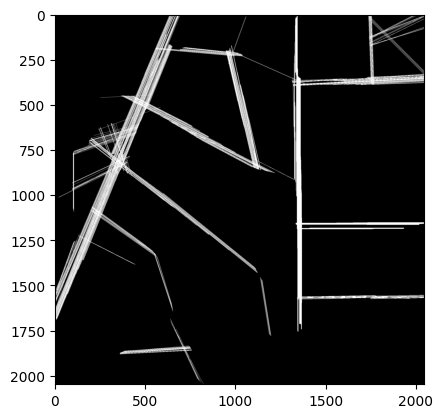

In [192]:
print("This is Sobel Model:")
x = boundaryDetector.Sobel()
houghTransformation = boundaryDetector.Hough_Transform(x)
boundaryDetector.Decision_Metrics(houghTransformation)
plt.imshow(houghTransformation,cmap='gray')
plt.show()

This is Canny Model:


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.3546
Recall: 0.2808
F1 Score: 0.3135
Accuracy: 0.9071
SSIM: 0.7770


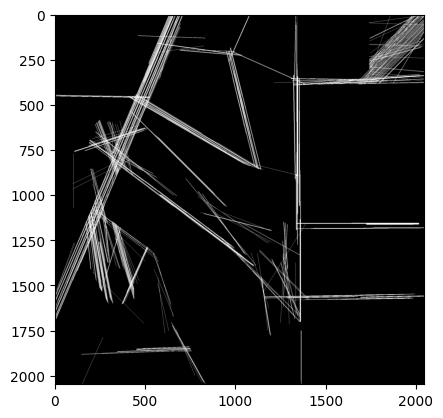

In [193]:
print("This is Canny Model:")
x = boundaryDetector.Canny()
houghTransformation = boundaryDetector.Hough_Transform(x)
boundaryDetector.Decision_Metrics(houghTransformation)
plt.imshow(houghTransformation,cmap='gray')
plt.show()

This is Laplacian Model:


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.4088
Recall: 0.4748
F1 Score: 0.4393
Accuracy: 0.9085
SSIM: 0.7797


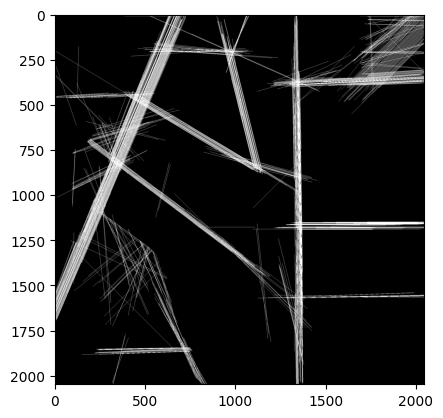

In [194]:
print("This is Laplacian Model:")
x = boundaryDetector.Laplacian_filter()
houghTransformation = boundaryDetector.Hough_Transform(x)
boundaryDetector.Decision_Metrics(houghTransformation)
plt.imshow(houghTransformation,cmap='gray')
plt.show()

This is Hybrid_Canny_Sobel model:


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.4213
Recall: 0.2211
F1 Score: 0.2900
Accuracy: 0.9183
SSIM: 0.7739


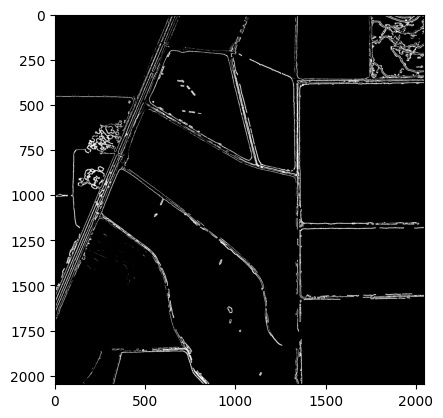

In [195]:

print("This is Hybrid_Canny_Sobel model:")
x = boundaryDetector.Hybrid_Canny_Sobel()
boundaryDetector.Decision_Metrics(x)
plt.imshow(x,cmap='gray')
plt.show()

This is Hybrid_Laplacian_Sobel model:


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Precision: 0.4664
Recall: 0.2756
F1 Score: 0.3465
Accuracy: 0.9215
SSIM: 0.7740


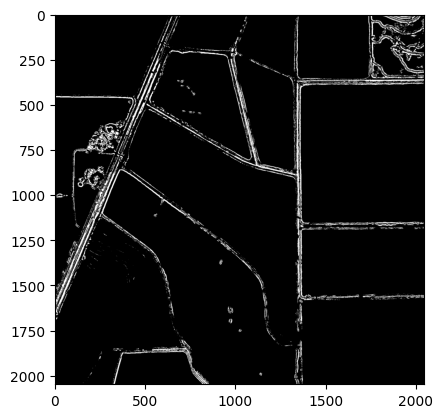

In [196]:
print("This is Hybrid_Laplacian_Sobel model:")
x = boundaryDetector.Hybrid_Laplacian_Sobel()
boundaryDetector.Decision_Metrics(x)
plt.imshow(x,cmap='gray')
plt.show()

This is Hybrid_Laplacian_Canny model:
Precision: 0.3846
Recall: 0.1115
F1 Score: 0.1729
Accuracy: 0.9195
SSIM: 0.7723


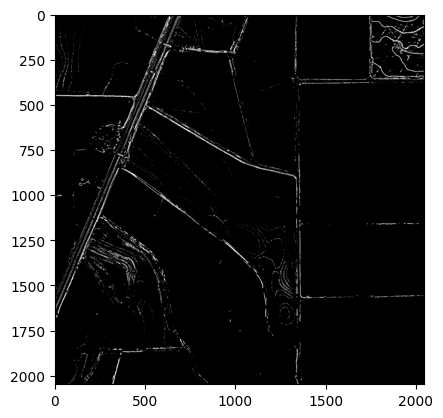

In [197]:
print("This is Hybrid_Laplacian_Canny model:")
x = boundaryDetector.Hybrid_Laplacian_Canny()
boundaryDetector.Decision_Metrics(x)
plt.imshow(x,cmap='gray')
plt.show()

This is Canny_logic model:
Precision: 0.3697
Recall: 0.1178
F1 Score: 0.1787
Accuracy: 0.9182
SSIM: 0.7726


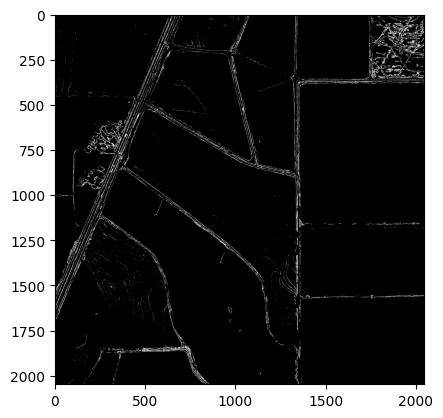

In [198]:
print("This is Canny_logic model:")
x = boundaryDetector.Canny_logic()
boundaryDetector.Decision_Metrics(x)
plt.imshow(x,cmap='gray')
plt.show()

**  TESTING THE DATASET WITH CONVOLUTIONAL NEURAL NETWORK**

In [199]:
import zipfile

def extract_zip(file_name):
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(f'Extracted {file_name}')

# Extract satellite images and ground truth images
extract_zip('satellite_images.zip')
extract_zip('groundtruth_images.zip')


Extracted satellite_images.zip
Extracted groundtruth_images.zip


In [200]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


def load_images_from_folder(folder):
    images = []
    files = sorted(os.listdir(folder))  # Sort the file names
    for filename in files:
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize images to 128x128
            images.append(img.astype('float32') / 255.0)  # Normalize images
    return np.array(images)

# Paths to your datasets
path_to_satellite_imgs = '/content/satellite_images'
path_to_ground_truths = '/content/groundtruth_images'

# After loading:
print("Satellite images loaded:", os.listdir(path_to_satellite_imgs)[:5])  # Print first 5 file names
print("Ground truth images loaded:", os.listdir(path_to_ground_truths)[:5])  # Print first 5 file names


# Loading and preparing datasets
satellite_imgs = load_images_from_folder(path_to_satellite_imgs)
ground_truths = load_images_from_folder(path_to_ground_truths)
ground_truths = (ground_truths > 0.5).astype(np.float32)  # Ensure binary ground truth

def pair_images(satellite_folder, groundtruth_folder):
    satellite_images = sorted(os.listdir(satellite_folder))
    groundtruth_images = sorted(os.listdir(groundtruth_folder))

    # Implement pairing logic here if names don't match directly
    # Example: strip parts of the names, or sort them according to your custom rules

    paired_satellite = []
    paired_groundtruth = []

    for sat_image in satellite_images:
        # Assuming naming convention allows direct matching or you extract the ids
        match_name = 'groundtruth_' + sat_image  # Adjust based on actual pattern
        if match_name in groundtruth_images:
            paired_satellite.append(cv2.imread(os.path.join(satellite_folder, sat_image), cv2.IMREAD_GRAYSCALE))
            paired_groundtruth.append(cv2.imread(os.path.join(groundtruth_folder, match_name), cv2.IMREAD_GRAYSCALE))

    return np.array(paired_satellite, dtype=np.float32) / 255.0, np.array(paired_groundtruth, dtype=np.float32) / 255.0


Satellite images loaded: ['image3.jpg', 'image1.jpg', 'image6.jpg', 'image5.jpg', 'image4.jpg']
Ground truth images loaded: ['image6_groundtruth.jpg', 'image4_groundtruth.jpg', 'image3_groundtruth.jpg', 'image5_groundtruth.jpg', 'image1_groundtruth.jpeg']


In [201]:
def unet(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoding path
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Decoding path
    up1 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=-1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=-1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer
    conv_final = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=conv_final)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [177]:
model = unet()
model.fit(satellite_imgs, ground_truths, epochs=50, batch_size=3, validation_split=0.2)


Epoch 1/50
2/2 [==============================] - 3s 652ms/step - loss: 0.6897 - accuracy: 0.9295 - val_loss: 0.6852 - val_accuracy: 0.9710
Epoch 2/50
2/2 [==============================] - 1s 460ms/step - loss: 0.6860 - accuracy: 0.9595 - val_loss: 0.6823 - val_accuracy: 0.9755
Epoch 3/50
2/2 [==============================] - 2s 830ms/step - loss: 0.6834 - accuracy: 0.9622 - val_loss: 0.6789 - val_accuracy: 0.9759
Epoch 4/50
2/2 [==============================] - 2s 447ms/step - loss: 0.6804 - accuracy: 0.9625 - val_loss: 0.6750 - val_accuracy: 0.9760
Epoch 5/50
2/2 [==============================] - 1s 412ms/step - loss: 0.6768 - accuracy: 0.9626 - val_loss: 0.6704 - val_accuracy: 0.9760
Epoch 6/50
2/2 [==============================] - 1s 444ms/step - loss: 0.6726 - accuracy: 0.9626 - val_loss: 0.6644 - val_accuracy: 0.9761
Epoch 7/50
2/2 [==============================] - 1s 466ms/step - loss: 0.6671 - accuracy: 0.9627 - val_loss: 0.6566 - val_accuracy: 0.9761
Epoch 8/50
2/2 [====

In [178]:
# Assuming you've trained your model and you have satellite_imgs as your input
predictions = model.predict(satellite_imgs)  # Make predictions


1/1 [==============================] - 0s 461ms/step


In [179]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from skimage.metrics import structural_similarity as ssim

# Ensure predictions are reshaped if they're coming from a model with sigmoid activation
predictions = (predictions > 0.5).astype(np.float32)  # Thresholding to get binary output

for i in range(len(predictions)):
    pred = predictions[i].reshape(ground_truths[i].shape).squeeze()  # Adjust dimensions and squeeze if necessary
    gt = ground_truths[i].squeeze()

    pred_flat = pred.flatten()
    gt_flat = gt.flatten()

    prec = precision_score(gt_flat, pred_flat, zero_division=0)
    rec = recall_score(gt_flat, pred_flat, zero_division=0)
    f1 = f1_score(gt_flat, pred_flat, zero_division=0)
    acc = accuracy_score(gt_flat, pred_flat)
    ssim_index = ssim(gt, pred, data_range=pred.max() - pred.min())

    print(f"Image {i+1} - Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, SSIM: {ssim_index:.4f}")


Image 1 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9730, SSIM: nan
Image 2 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9412, SSIM: nan
Image 3 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9651, SSIM: nan
Image 4 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9713, SSIM: nan
Image 5 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9800, SSIM: nan
Image 6 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9721, SSIM: nan


/usr/local/lib/python3.10/dist-packages/skimage/metrics/_structural_similarity.py:230: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/usr/local/lib/python3.10/dist-packages/skimage/metrics/_structural_similarity.py:230: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/usr/local/lib/python3.10/dist-packages/skimage/metrics/_structural_similarity.py:230: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/usr/local/lib/python3.10/dist-packages/skimage/metrics/_structural_similarity.py:230: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/usr/local/lib/python3.10/dist-packages/skimage/metrics/_structural_similarity.py:230: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/usr/local/lib/python3.10/dist-packages/skimage/metrics/_structural_similarity.py:230: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


In [180]:
print("Unique values in predictions:", np.unique(predictions))
print("Check some prediction arrays:", predictions[0].flatten())


Unique values in predictions: [0.]
Check some prediction arrays: [0. 0. 0. ... 0. 0. 0.]


In [181]:
def safe_ssim(gt, pred):
    if np.var(gt) == 0 and np.var(pred) == 0:
        return 1.0  # Both images are constant
    elif np.var(gt) == 0 or np.var(pred) == 0:
        return 0.0  # One image is constant but not the other
    else:
        return ssim(gt, pred, data_range=pred.max() - pred.min())

# Calculate SSIM in a safe manner
ssim_scores = [safe_ssim(gt.reshape(128, 128), pred.reshape(128, 128)) for gt, pred in zip(ground_truths, predictions)]


In [182]:
for i, (pred, gt) in enumerate(zip(predictions, ground_truths)):
  pred = pred.reshape(gt.shape).squeeze()  # Adjust dimensions and squeeze if necessary
  gt = gt.squeeze()

  pred_flat = pred.flatten()
  gt_flat = gt.flatten()

  prec = precision_score(gt_flat, pred_flat, zero_division=0)
  rec = recall_score(gt_flat, pred_flat, zero_division=0)
  f1 = f1_score(gt_flat, pred_flat, zero_division=0)
  acc = accuracy_score(gt_flat, pred_flat)
  ssim_index = ssim(gt, pred, data_range=gt.max() - gt.min())

  print(f"Image {i+1} - Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, SSIM: {ssim_index:.4f}")



Image 1 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9730, SSIM: 0.7427
Image 2 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9412, SSIM: 0.6234
Image 3 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9651, SSIM: 0.7003
Image 4 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9713, SSIM: 0.7680
Image 5 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9800, SSIM: 0.8130
Image 6 - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9721, SSIM: 0.7584


In [183]:
unique, counts = np.unique(ground_truths.flatten(), return_counts=True)
print(dict(zip(unique, counts)))  # This will show how many pixels belong to each class


{0.0: 95074, 1.0: 3230}


In [184]:
import numpy as np
from sklearn.metrics import precision_score

# Assume 'predictions' is an array of images predicted by your model
# and 'ground_truths' is an array of your actual labels.

# Check shapes first
print("Predictions shape:", predictions.shape)
print("Ground truths shape:", ground_truths.shape)

# Make sure they match in the first dimension (number of images)
assert predictions.shape[0] == ground_truths.shape[0], "Mismatch in number of images"

# Example threshold testing
thresholds = np.linspace(0.1, 0.3, 9)
for thresh in thresholds:
    # Apply threshold and flatten
    pred_labels = (predictions > thresh).astype(np.float32).reshape(-1)  # Flatten all predictions
    gt_labels = ground_truths.reshape(-1)  # Flatten all ground truths

    # Ensure both flattened arrays are the same length
    assert pred_labels.shape == gt_labels.shape, "Mismatch in the flattened array sizes"

    # Calculate precision
    precision = precision_score(gt_labels, pred_labels)
    print(f"Threshold: {thresh}, Precision: {precision}")



Predictions shape: (6, 128, 128, 1)
Ground truths shape: (6, 128, 128)
Threshold: 0.1, Precision: 0.0
Threshold: 0.125, Precision: 0.0
Threshold: 0.15, Precision: 0.0
Threshold: 0.175, Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Threshold: 0.2, Precision: 0.0
Threshold: 0.22499999999999998, Precision: 0.0
Threshold: 0.25, Precision: 0.0
Threshold: 0.275, Precision: 0.0
Threshold: 0.3, Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

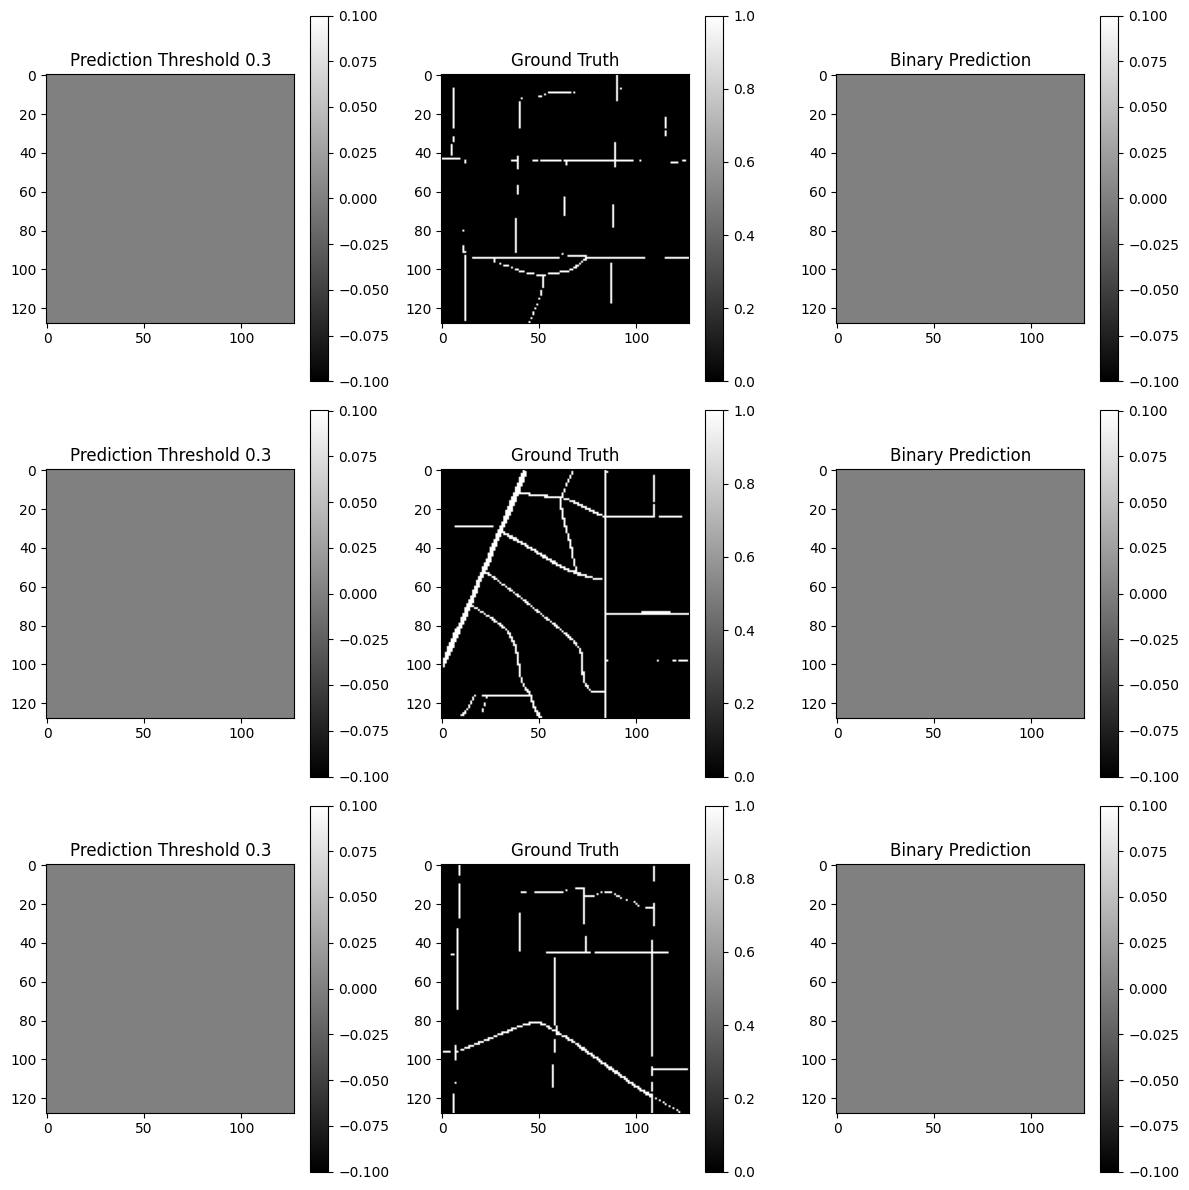

In [185]:
import matplotlib.pyplot as plt

# Display a few images with their predictions and ground truths
num_imgs_to_display = 3
plt.figure(figsize=(12, num_imgs_to_display * 4))
for i in range(num_imgs_to_display):
    plt.subplot(num_imgs_to_display, 3, i*3 + 1)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title(f'Prediction Threshold {thresholds[-1]}')
    plt.colorbar()

    plt.subplot(num_imgs_to_display, 3, i*3 + 2)
    plt.imshow(ground_truths[i].squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.colorbar()

    plt.subplot(num_imgs_to_display, 3, i*3 + 3)
    plt.imshow((predictions[i] > thresholds[-1]).squeeze(), cmap='gray')
    plt.title('Binary Prediction')
    plt.colorbar()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 428ms/step
Sample raw prediction values: [0.407365   0.3535468  0.31308144 0.2914331  0.2672826  0.25420168
 0.24319448 0.23741914 0.2309706  0.22811234]


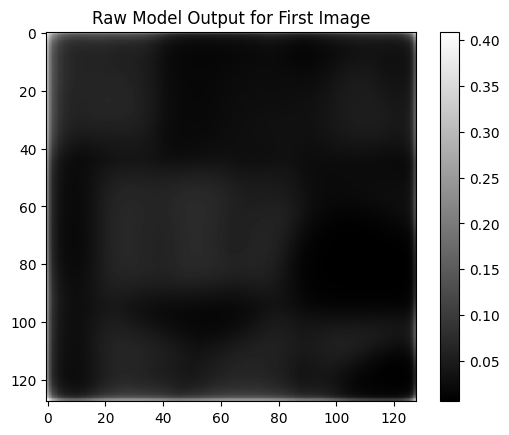

In [186]:
#testing code:
raw_predictions = model.predict(satellite_imgs)
print("Sample raw prediction values:", raw_predictions[0].flatten()[:10])  # Check the first few prediction values

# Visualize the output of the first prediction without thresholding
plt.imshow(raw_predictions[0].squeeze(), cmap='gray')
plt.colorbar()
plt.title('Raw Model Output for First Image')
plt.show()


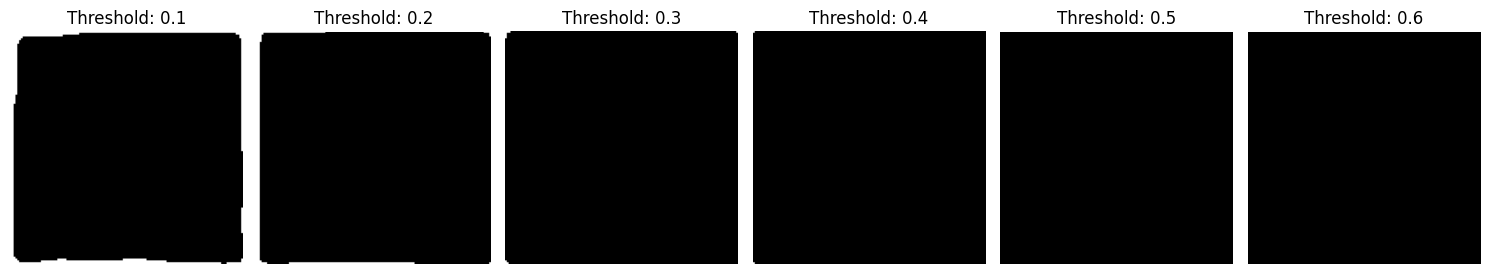

In [187]:
#Testing code
# Try different thresholds to find the best cutoff that starts showing meaningful segmentation
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, thresh in enumerate(thresholds):
    pred_thresh = (raw_predictions[0] > thresh).astype(int)
    axes[i].imshow(pred_thresh.squeeze(), cmap='gray')
    axes[i].set_title(f'Threshold: {thresh}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 414ms/step
Unique values in predictions: [0.]
Sum of all predictions (should not be 0): 0.0


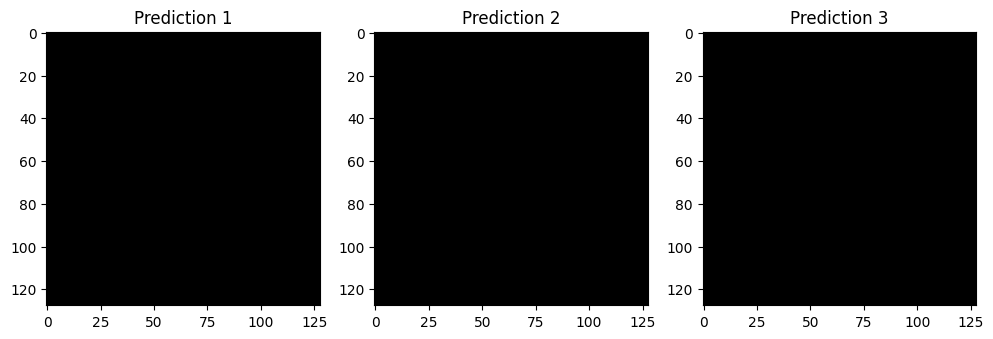

In [188]:
import numpy as np

# Make a prediction
predictions = model.predict(satellite_imgs)

# Applying threshold to convert probabilities to binary
predictions_binary = (predictions > 0.5).astype(np.float32)

# Check if predictions are all zeros or have any variance
print("Unique values in predictions:", np.unique(predictions_binary[0]))
print("Sum of all predictions (should not be 0):", np.sum(predictions_binary))

# Visualization
plt.figure(figsize=(12, 6))
for i in range(3):  # Display first 3 predictions
    plt.subplot(1, 3, i + 1)
    plt.imshow(predictions_binary[i].reshape(128, 128), cmap='gray')
    plt.title(f'Prediction {i+1}')
plt.show()


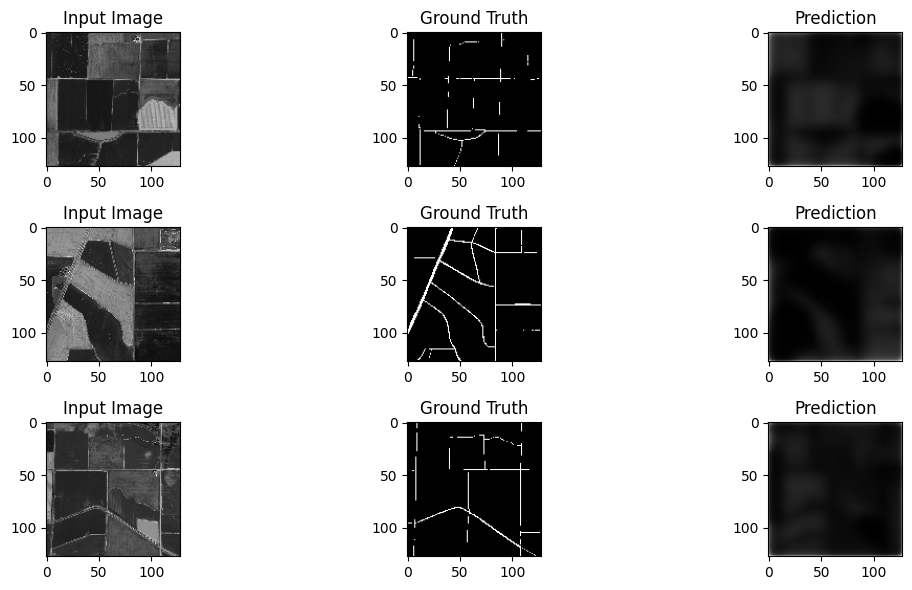

In [189]:
plt.figure(figsize=(12, 6))
for i in range(3):  # Just show first 3 images
    plt.subplot(3, 3, 1 + i * 3)
    plt.imshow(satellite_imgs[i], cmap='gray')
    plt.title('Input Image')
    plt.subplot(3, 3, 2 + i * 3)
    plt.imshow(ground_truths[i], cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(3, 3, 3 + i * 3)
    plt.imshow(predictions[i], cmap='gray')
    plt.title('Prediction')
plt.tight_layout()
plt.show()
